# Imports and installations

In [ ]:
!pip install catboost
!pip install shap
!pip install flaml
!pip install optuna
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import ast
import six
import sys

In [ ]:
# Third-party imports
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap
import optuna
from optuna.samplers import TPESampler
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              RandomForestRegressor, StackingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFECV
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  LogisticRegressionCV, SGDClassifier)
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, r2_score,
                             matthews_corrcoef, average_precision_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder,
                                   RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from flaml import AutoML
from mlxtend.feature_selection import (SequentialFeatureSelector as SFS)
from mlxtend.plotting import (plot_sequential_feature_selection as plot_sfs)

# Fixing joblib import issue
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set pandas display options
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)

In [ ]:
pd.set_option('display.precision', 3)

In [ ]:
random_state=20

In [ ]:
joblib.__version__

'1.3.2'

# Download and preprocess data

In [ ]:
train = pd.read_excel('/content/cardiovascular-prognosis/Preprocessed data/Combined target/Imputed data/train_abcd.xlsx', index_col=0, header=0)
test = pd.read_excel('/content/cardiovascular-prognosis/Preprocessed data/Combined target/Imputed data/test_abcd.xlsx', index_col=0, header=0)

In [ ]:
train.shape

(363, 36)

In [ ]:
train.shape[0] + test.shape[0]

484

In [ ]:
# Define the URLs of the train and test Excel files
train_file_url = "/content/cardiovascular-prognosis/Preprocessed data/Combined target/Imputed data/train_d.xlsx"  # Replace with the actual URL
test_file_url = "/content/cardiovascular-prognosis/Preprocessed data/Combined target/Imputed data/test_d.xlsx"    # Replace with the actual URL

# Download the train and test Excel files
train_df = pd.read_excel(train_file_url, index_col=0, header=0)
test_df = pd.read_excel(test_file_url, index_col=0, header=0)

# Combine the train and test DataFrames
train_test_df = pd.concat([train_df, test_df], ignore_index=True)

# Reset the indexes
train_test_df.reset_index(drop=True, inplace=True)
train_test_df.insert(0, "Index", train_test_df.index)


# Save the combined DataFrame as a new Excel file
train_test_df.to_excel("train_test_d.xlsx", index=False)

In [ ]:
#additional cleaning
train.columns = train.columns.to_series().apply(lambda x: x.split("'")[-2])
test.columns = test.columns.to_series().apply(lambda x: x.split("'")[-2])

In [ ]:
def rename_cyrillic_columns(df):
    column_mapping = {'Пол': 'Gender',
        'Возраст': 'Age',
        'ИМТ': 'BMI',
        'систол. АД': 'Systolic BP',
        'ЧСС': 'Heart Rate',
        'Давность болевого синдрома': 'Duration of Pain',
        'Cегмент ST': 'ST Segment',
        'Передняя стенка ЛЖ': 'Anterior LV Wall',
        'Боковая стенка ЛЖ': 'Lateral LV Wall',
        'Класс Killip': 'Killip Class',
        'Риск GRACE, баллы': 'GRACE Risk Score',
        'пост-ИМ': 'Post-MI',
        'пост-ОНМК': 'Post-Stroke',
        'пост-стент': 'Post-Stent',
        'ФП': 'Atrial Fibrillation',
        'ГБ': 'Hypertension',
        'СД': 'Diabetes',
        'МФА': 'Atherosclerosis ',
        'Ожирение, степень': 'Obesity',
        'Анемия, степень': 'Anemia',
        'Индекс коморбидности': 'Comorbidity Index',
        'Наследственность': 'Family History',
        'TnT-ПО, нг/л': 'TnT PO',
        'Хсобщ, ммоль/л': 'Total Cholesterol',
        'ТГц, ммоль/л': 'Triglycerides',
        'Гемоглобин, г/л': 'Hemoglobin',
        'Глюкоза, ммоль/л': 'Glucose',
        'СКФ EPI': 'eGFR EPI',
        'Креатинин, мкмоль/л': 'Creatinine',
        'иКДО ЛЖ': 'LV EDV',
        'иКСО ЛЖ': 'LV ESV',
        'ФВ ЛЖ': 'LV EF',
        'иММ ЛЖ': 'LV Mass',
        'ЛП': 'Lipoprotein',
        'ИНЛС ЛЖ': 'LV Infarct Size',
        'combined': 'combined'
    }

    df.rename(columns=column_mapping, inplace=True)

In [ ]:
rename_cyrillic_columns(train)
rename_cyrillic_columns(test)

In [ ]:
not_use = ['combined','Anemia','Obesity']

In [ ]:
X_train,X_test = train.drop(not_use,1).copy(), test.drop(not_use,1).copy()
y_train,y_test = train['combined'], test['combined']

# AutoML baseline

In [ ]:
baseline_model = AutoML()

settings = {
    "metric": 'roc_auc',
    "estimator_list": ['lgbm','catboost', 'rf'], # list of ML learners
    "task": 'classification', # task type
    "log_file_name": '/content/drive/MyDrive/1231_ABCD/baseline_model_anem.log',  # flaml log file
    "time_budget": 2000,
    "early_stop": True,
    "eval_method": "cv",
    "n_splits": 10,
    "verbose":2,
    "seed":random_state,
    "split_type":"stratified"

}

In [ ]:
baseline_model.fit(X_train=X_train, y_train=y_train, **settings)

In [ ]:
# Saving model
joblib.dump(baseline_model, '/content/drive/MyDrive/1231_ABCD/baseline_anem.pkl')

['/content/drive/MyDrive/1231_ABCD/baseline_anem.pkl']

## Results

In [ ]:
classifiers_predictions = {
    'AutoML baseline' : baseline_model.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

,PR_AUC,ROC_AUC,F1-score,Precision,Recall,MCC,Accuracy
AutoML baseline,0.534,0.829,0.567,0.76,0.452,0.443,0.76


In [ ]:
baseline_model.best_estimator

'rf'

In [ ]:
baseline_model.best_result

{'pred_time': 0.0004020459301120884,
 'wall_clock_time': 1945.3097677230835,
 'metric_for_logging': {'pred_time': 0.0004020459301120884},
 'val_loss': 0.21913322185061315,
 'training_iteration': 1,
 'config': {'n_estimators': 53,
  'max_leaves': 8,
  'max_features': 0.508593751825132,
  'criterion': 'entropy'},
 'config/n_estimators': 53,
 'config/max_leaves': 8,
 'config/max_features': 0.508593751825132,
 'config/criterion': 'entropy',
 'experiment_tag': 'exp',
 'time_total_s': 1.706892728805542}

In [ ]:
1 - baseline_model.best_loss

0.7808667781493869

<Axes: >

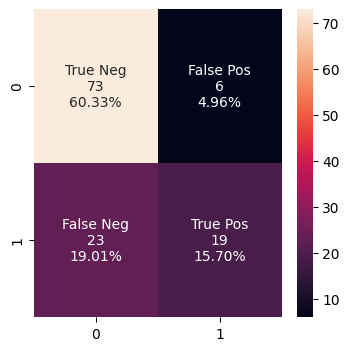

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,baseline_model.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

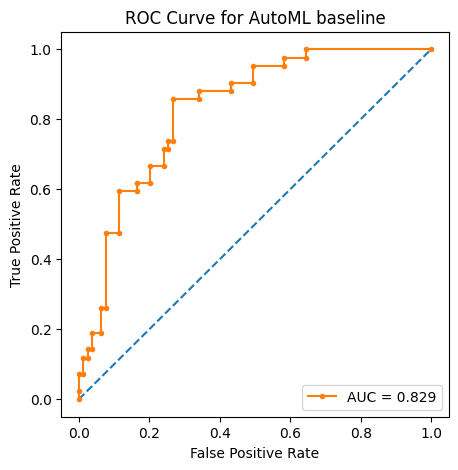

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, baseline_model.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for AutoML baseline")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

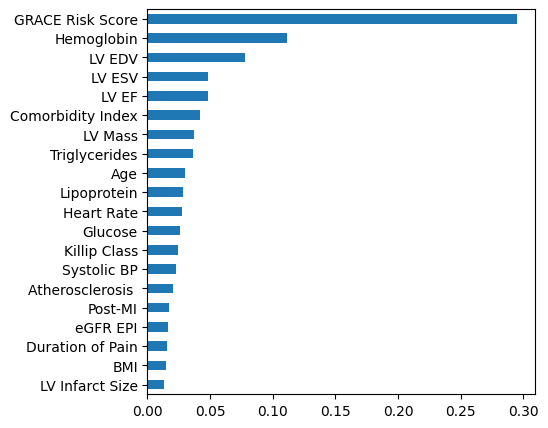

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(baseline_model.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

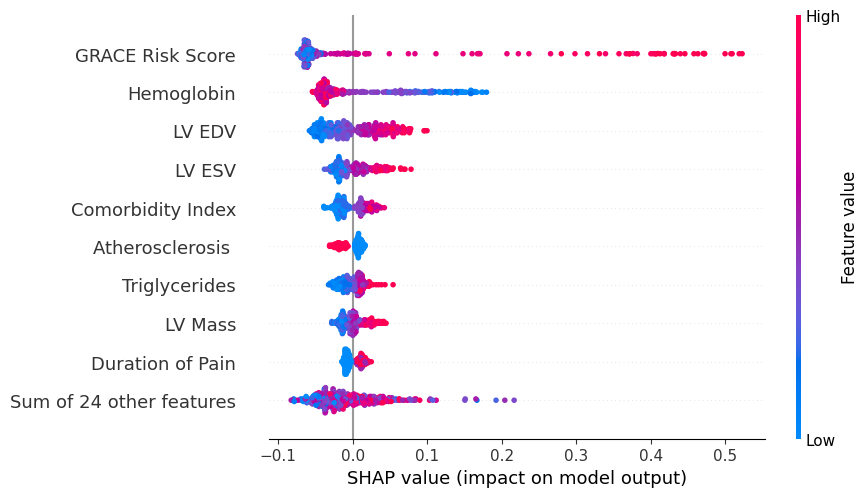

In [ ]:
explainer = shap.TreeExplainer(baseline_model.model.estimator)
shap_values = explainer.shap_values(X_train)
shap.plots.beeswarm(explainer(X_train)[:,:,1])

# CatBoost tuning

In [ ]:
def objective(trial):

    model = CatBoostClassifier(
        objective= trial.suggest_categorical("objective", ["Logloss"]),
        iterations=trial.suggest_int( "iterations",10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
        depth=trial.suggest_int("depth", 2,6),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-1, 150.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-1, 10.0, log=True),
        auto_class_weights= trial.suggest_categorical("auto_class_weights", [None, 'Balanced', 'SqrtBalanced']),
        verbose=False,
        random_state= trial.suggest_categorical('random_state',[random_state]),
        grow_policy = trial.suggest_categorical('grow_policy',['SymmetricTree','Depthwise', 'Lossguide']),
        rsm=trial.suggest_float("rsm", 0.3, 1.0),
        subsample=trial.suggest_float("subsample", 0.3, 0.9)
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state,)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_hem", direction="maximize",sampler = sampler)
                            #storage ='sqlite:///drive/MyDrive/1231_ABCD/catboost_hem.db',load_if_exists=True)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

In [ ]:
catboost = CatBoostClassifier(**best_params)
catboost.fit(X_train,y_train)

In [ ]:
# Saving model
joblib.dump(catboost, '/content/drive/MyDrive/1231_ABCD/catboost_strat_anem.joblib')

# Forward feature selection

In [ ]:
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_strat_anem.joblib')

In [ ]:
params = catboost.get_params()
params['logging_level'] = 'Silent'

In [ ]:
catboost = CatBoostClassifier(**params)
catboost.fit(X_train,y_train)

In [ ]:
sfsl = SFS(estimator = catboost, forward = True, k_features = (1,20), floating=False, scoring = 'roc_auc', cv=5, verbose=1,n_jobs=2)
sfsl.fit(X_train,y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  33 out of  33 | elapsed:   38.8s finished
Features: 1/20[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:  1.8min finished
Features: 2/20[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  31 out of  31 | elapsed:  2.6min finished
Features: 3/20[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  5.7min finished
Features: 4/20[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  29 out of  29 | elapsed:  6.0min finished
Features: 5/20[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed:  6.4min finished
Features: 6/20[Parallel(n_jobs=2)]: Using backend LokyBacken

SequentialFeatureSelector(estimator=<catboost.core.CatBoostClassifier object at 0x7dcb205a3d30>,
                          k_features=(1, 20), n_jobs=2, scoring='roc_auc',
                          verbose=1)

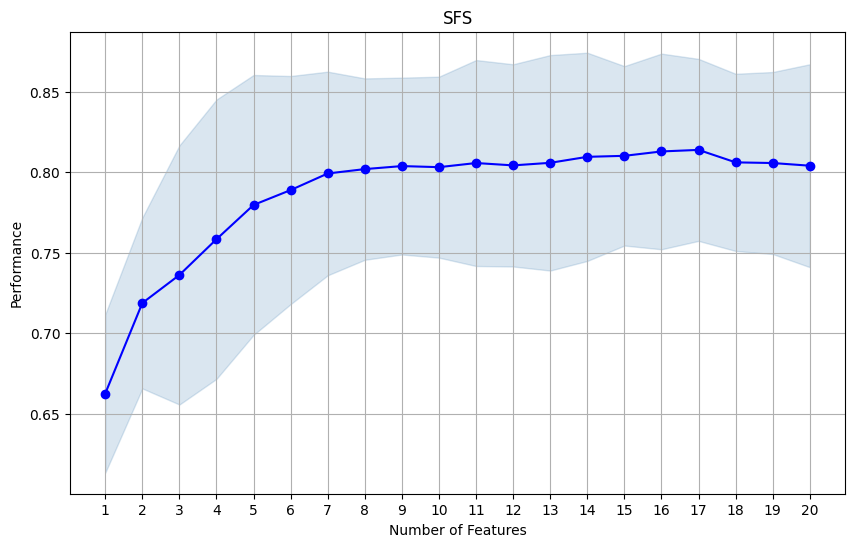

In [ ]:
fig1 = plot_sfs(sfsl.get_metric_dict(),kind = 'std_dev',figsize=(10,6))
plt.title('SFS')
plt.grid()
plt.show()

In [ ]:
joblib.dump(sfsl.get_metric_dict(), '/content/drive/MyDrive/1231_ABCD/metric_dict_anem.zip')

['/content/drive/MyDrive/1231_ABCD/metric_dict_anem.zip']

In [ ]:
scores = [element['avg_score'] for element in sfsl.get_metric_dict().values()]
best_combination_index = np.argmax(scores) + 1
best_combination = sfsl.get_metric_dict()[best_combination_index]['feature_names']
print('Best number of features: ', len(best_combination))
print(sfsl.get_metric_dict()[best_combination_index])

Best number of features:  17
{'feature_idx': (0, 1, 2, 5, 6, 10, 13, 14, 15, 16, 17, 18, 19, 20, 29, 31, 32), 'cv_scores': array([0.88379705, 0.75777414, 0.85916667, 0.82978723, 0.7387234 ]), 'avg_score': 0.8138496999454446, 'feature_names': ('Gender', 'Age', 'BMI', 'Duration of Pain', 'ST Segment', 'GRACE Risk Score', 'Post-Stent', 'Atrial Fibrillation', 'Hypertension', 'Diabetes', 'Atherosclerosis ', 'Comorbidity Index', 'Family History', 'TnT PO', 'LV EF', 'Lipoprotein', 'LV Infarct Size'), 'ci_bound': 0.0726813398356158, 'std_dev': 0.05654855161610539, 'std_err': 0.028274275808052696}


# Final catboost optimization

In [ ]:
metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_anem.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = list(best_combination)

In [ ]:
X_train,X_test = train.drop(not_use,1).copy()[s], test.drop(not_use,1).copy()[s]
y_train,y_test = train['combined'], test['combined']

In [ ]:
def objective(trial):

    model = CatBoostClassifier(
        objective= trial.suggest_categorical("objective", ["Logloss"]),
        iterations=trial.suggest_int( "iterations",10, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
        depth=trial.suggest_int("depth", 2,12),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-1, 150.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-1, 10.0, log=True),
        auto_class_weights= trial.suggest_categorical("auto_class_weights", [None, 'Balanced', 'SqrtBalanced']),
        verbose=False,
        random_state= trial.suggest_categorical('random_state',[random_state]),
        grow_policy = trial.suggest_categorical('grow_policy',['SymmetricTree','Depthwise', 'Lossguide']),
        rsm=trial.suggest_float("rsm", 0.3, 1.0),
        subsample=trial.suggest_float("subsample", 0.3, 1.0)
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state,)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_selected_anem", direction="maximize",sampler = sampler)
                            #storage ='sqlite:///drive/MyDrive/1231_ABCD/catboost_selected_anem.db',load_if_exists=True)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8663392857142858

Optimized parameters: {'objective': 'Logloss', 'iterations': 246, 'learning_rate': 0.4382930646180629, 'depth': 6, 'l2_leaf_reg': 0.756561548878142, 'random_strength': 8.642896704664103, 'auto_class_weights': None, 'random_state': 20, 'grow_policy': 'SymmetricTree', 'rsm': 0.8305875545547606, 'subsample': 0.3114877356384138}



In [ ]:
catboost_selected = CatBoostClassifier(**best_params)
catboost_selected.fit(X_train,y_train)

0:	learn: 0.5834326	total: 2.16ms	remaining: 530ms
1:	learn: 0.5138494	total: 3.52ms	remaining: 429ms
2:	learn: 0.4763604	total: 4.7ms	remaining: 381ms
3:	learn: 0.4619121	total: 5.71ms	remaining: 346ms
4:	learn: 0.4345163	total: 6.8ms	remaining: 328ms
5:	learn: 0.4143790	total: 7.92ms	remaining: 317ms
6:	learn: 0.3854842	total: 9.03ms	remaining: 308ms
7:	learn: 0.3731173	total: 9.88ms	remaining: 294ms
8:	learn: 0.3675623	total: 10.9ms	remaining: 287ms
9:	learn: 0.3507055	total: 12ms	remaining: 283ms
10:	learn: 0.3390936	total: 13.1ms	remaining: 279ms
11:	learn: 0.3243242	total: 14.1ms	remaining: 275ms
12:	learn: 0.3095453	total: 15.2ms	remaining: 272ms
13:	learn: 0.2958117	total: 16.3ms	remaining: 270ms
14:	learn: 0.2831156	total: 17.3ms	remaining: 267ms
15:	learn: 0.2769550	total: 18.4ms	remaining: 264ms
16:	learn: 0.2695055	total: 19.4ms	remaining: 261ms
17:	learn: 0.2573295	total: 20.6ms	remaining: 260ms
18:	learn: 0.2423095	total: 21.6ms	remaining: 258ms
19:	learn: 0.2246577	total

In [ ]:
# Saving model
joblib.dump(catboost_selected, '/content/drive/MyDrive/1231_ABCD/catboost_selected_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/catboost_selected_anem.joblib']

# Another models

In [ ]:
X_train,X_test = train.drop(not_use,1).copy(), test.drop(not_use,1).copy()
y_train,y_test = train['combined'], test['combined']

## Random Forest

In [ ]:
def objective(trial):

    model = RandomForestClassifier(
        criterion= trial.suggest_categorical('criterion',['gini', 'entropy']),
        n_estimators=trial.suggest_int( "n_estimators",10, 500),
        max_depth=trial.suggest_int("max_depth", 2,11),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2,100),
        random_state= trial.suggest_categorical('random_state',[random_state]),
        warm_start= trial.suggest_categorical('warm_start',[True,False]),
        class_weight = trial.suggest_categorical('class_weight',[None, 'balanced', 'balanced_subsample']),
        max_features=trial.suggest_float("max_features", 0.5, 1.0),
        max_samples=trial.suggest_float("max_samples", 0.5, 1.0),
        n_jobs=-1
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_rf_hem", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8644642857142857

Optimized parameters: {'criterion': 'entropy', 'n_estimators': 387, 'max_depth': 9, 'min_samples_leaf': 2, 'random_state': 20, 'warm_start': True, 'class_weight': 'balanced', 'max_features': 0.7899996572920672, 'max_samples': 0.8601348698784559}



In [ ]:
rf = RandomForestClassifier(**best_params)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, max_features=0.7899996572920672,
                       max_samples=0.8601348698784559, min_samples_leaf=2,
                       n_estimators=387, random_state=20, warm_start=True)

In [ ]:
classifiers_predictions = {
    'RF' : rf.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

,PR_AUC,ROC_AUC,F1-score,Precision,Recall,MCC,Accuracy
RF,0.521,0.823,0.559,0.731,0.452,0.422,0.752


In [ ]:
# Saving model
joblib.dump(rf, '/content/drive/MyDrive/1231_ABCD/rf_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/rf_anem.joblib']

## Logreg

In [ ]:
def objective(trial):

    model = LogisticRegression(
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2']),
        C = trial.suggest_float('C', 0.001, 100,log=True),
        random_state= trial.suggest_categorical('random_state',[random_state]),
        solver = trial.suggest_categorical('solver', ['liblinear'])
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_logreg_hem", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8385714285714286

Optimized parameters: {'penalty': 'l2', 'C': 0.011902693626264787, 'random_state': 20, 'solver': 'liblinear'}



In [ ]:
logreg = LogisticRegression(**best_params)
logreg.fit(X_train,y_train)

LogisticRegression(C=0.011902693626264787, random_state=20, solver='liblinear')

In [ ]:
# Saving model
joblib.dump(logreg, '/content/drive/MyDrive/1231_ABCD/logreg_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/logreg_anem.joblib']

## SVM

In [ ]:
def objective(trial):

    model = SVC(
        C = trial.suggest_float('C', 0.001, 100,log=True),
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
        gamma = trial.suggest_float('gamma', 0.001, 10,log=True),
        random_state= trial.suggest_categorical('random_state',[random_state])
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc",
        n_jobs=-1
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_svm_hem", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8594642857142857

Optimized parameters: {'C': 0.5360496129541993, 'kernel': 'poly', 'gamma': 0.027901290874782925, 'random_state': 20}



In [ ]:
svm = SVC(**best_params)
svm.fit(X_train,y_train)

SVC(C=0.5360496129541993, gamma=0.027901290874782925, kernel='poly',
    random_state=20)

In [ ]:
# Saving model
joblib.dump(svm, '/content/drive/MyDrive/1231_ABCD/svm_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/svm_anem.joblib']

## Decision Tree

In [ ]:
def objective(trial):

    model = DecisionTreeClassifier(
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
        max_depth = trial.suggest_int('max_depth', 2, 32),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state,)

    scores = cross_val_score(
        model, X_test, y_test, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_decision_hem", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=300)

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.9056696428571429

Optimized parameters: {'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 15, 'min_samples_leaf': 11}



In [ ]:
dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=32, min_samples_leaf=11, min_samples_split=15)

In [ ]:
# Saving model
joblib.dump(dt, '/content/drive/MyDrive/1231_ABCD/decision_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/decision_anem.joblib']

## Naive Bayes

Naive Bayes has no hyperparameters, so there is nothing to tune

In [ ]:
# Create a Naive Bayes classifier (Gaussian Naive Bayes in this case)
nb = GaussianNB()
# Fit the classifier on the training data
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
print(f"Best score: {roc_auc_score(y_train, nb.predict_proba(X_train)[:,1])}\n")
print(f"Optimized parameters: {nb.get_params()}\n")

Best score: 0.774089149873215

Optimized parameters: {'priors': None, 'var_smoothing': 1e-09}



In [ ]:
# Saving model
joblib.dump(nb, '/content/drive/MyDrive/1231_ABCD/nb_anem.joblib')

['/content/drive/MyDrive/1231_ABCD/nb_anem.joblib']

# Final results evaluation with bootstrap

In [ ]:
def evaluate_metrics(classifiers, X_test, y_test, num_bootstrap=1000, random_state=random_state):
    metrics = ['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy']
    results = {}

    for clf_name, clf in classifiers.items():
        metric_scores = []
        for i in range(num_bootstrap):
            # Initialize random number generator
            rng = np.random.default_rng(random_state + i)

            # Bootstrap resampling
            num_samples = len(X_test)
            bootstrap_indices = rng.choice(num_samples, num_samples, replace=True)
            X_bootstrap = X_test.iloc[bootstrap_indices]
            y_bootstrap = y_test.iloc[bootstrap_indices]

            # Handle the case when only one class is present in y_bootstrap
            if len(np.unique(y_bootstrap)) == 1:
                continue

            if clf_name!='SVM':
              # Predict probabilities
              y_prob = clf.predict_proba(X_bootstrap)[:, 1]

            else:
              y_prob = clf.predict(X_bootstrap)

            # Calculate metrics
            y_prob_round = y_prob.round()
            pr_auc = average_precision_score(y_bootstrap, y_prob)
            roc_auc = roc_auc_score(y_bootstrap, y_prob)
            f1 = f1_score(y_bootstrap, y_prob_round)
            precision = precision_score(y_bootstrap, y_prob_round)
            recall = recall_score(y_bootstrap, y_prob_round)
            mcc = matthews_corrcoef(y_bootstrap, y_prob_round)
            accuracy = accuracy_score(y_bootstrap, y_prob_round)

            metric_scores.append((pr_auc, roc_auc, f1, precision, recall, mcc, accuracy))

        metric_scores = np.array(metric_scores)
        mean_scores = np.mean(metric_scores, axis=0)
        results[clf_name] = mean_scores

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)
    return results_df

In [ ]:
baseline = joblib.load('/content/drive/MyDrive/1231_ABCD/baseline_anem.pkl')
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_strat_anem.joblib')
catboost_selected = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_selected_anem.joblib')
rf = joblib.load('/content/drive/MyDrive/1231_ABCD/rf_anem.joblib')
logreg = joblib.load('/content/drive/MyDrive/1231_ABCD/logreg_anem.joblib')
svm = joblib.load('/content/drive/MyDrive/1231_ABCD/svm_anem.joblib')
dt = joblib.load('/content/drive/MyDrive/1231_ABCD/decision_anem.joblib')
nb = joblib.load('/content/drive/MyDrive/1231_ABCD/nb_anem.joblib')

metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_anem.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = list(best_combination)

X_train_sfs,X_test_sfs = train.copy().drop('combined',1)[s], test.copy().drop('combined',1)[s]
X_train,X_test = train.drop(not_use,1).copy(), test.drop(not_use,1).copy()
y_train,y_test = train['combined'], test['combined']

In [ ]:
classifiers = {
    'Catboost' : catboost
}
cat = evaluate_metrics(classifiers,X_test,y_test)

classifiers = {
    'Catboost after SFS' : catboost_selected
}
selected = evaluate_metrics(classifiers,X_test_sfs,y_test)
classifiers = {
    'RandomForest' : rf
}
rf = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'Logistic Regression' : logreg
}
logreg_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'SVM' : svm
}
svm_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'AutoMl Baseline' : baseline
}
automl = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'Decision Tree' : dt
}
dt_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'Naive Bayes' : nb
}
nb_ = evaluate_metrics(classifiers,X_test,y_test)

In [ ]:
res = pd.concat([cat,selected,rf,logreg_,svm_,automl,dt_,nb_])

In [ ]:
res.round(3).sort_values(by=['ROC_AUC','PR_AUC'],ascending=False).style.highlight_max()

,PR_AUC,ROC_AUC,F1-score,Precision,Recall,MCC,Accuracy
Logistic Regression,0.709000,0.829000,0.609000,0.737000,0.523000,0.467000,0.769000
AutoMl Baseline,0.693000,0.828000,0.565000,0.764000,0.453000,0.445000,0.761000
RandomForest,0.701000,0.823000,0.556000,0.735000,0.452000,0.423000,0.752000
Naive Bayes,0.630000,0.820000,0.580000,0.624000,0.547000,0.383000,0.727000
Catboost,0.678000,0.804000,0.555000,0.735000,0.451000,0.423000,0.752000
Decision Tree,0.560000,0.726000,0.479000,0.604000,0.401000,0.294000,0.700000
Catboost after SFS,0.624000,0.708000,0.486000,0.613000,0.407000,0.305000,0.704000
SVM,0.413000,0.580000,0.357000,0.581000,0.262000,0.210000,0.677000


# Feature Importance Analysis

Download models and data

In [ ]:
baseline = joblib.load('/content/drive/MyDrive/1231_ABCD/baseline_anem.pkl')
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_strat_anem.joblib')
catboost_selected = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_selected_anem.joblib')
rf = joblib.load('/content/drive/MyDrive/1231_ABCD/rf_anem.joblib')
logreg = joblib.load('/content/drive/MyDrive/1231_ABCD/logreg_anem.joblib')
svm = joblib.load('/content/drive/MyDrive/1231_ABCD/svm_anem.joblib')
dt = joblib.load('/content/drive/MyDrive/1231_ABCD/decision_anem.joblib')
nb = joblib.load('/content/drive/MyDrive/1231_ABCD/nb_anem.joblib')

metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_anem.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = list(best_combination)

X_train_sfs,X_test_sfs = train.copy().drop('combined',1)[s], test.copy().drop('combined',1)[s]
X_train,X_test = train.drop(not_use,1).copy(), test.drop(not_use,1).copy()
y_train,y_test = train['combined'], test['combined']

## Catboost on full feature set

<Axes: >

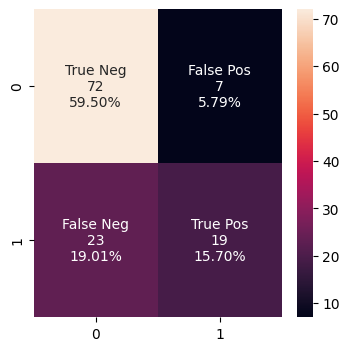

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,catboost.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

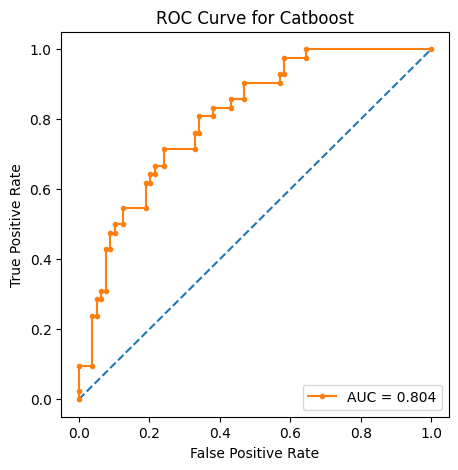

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, catboost.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, catboost.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

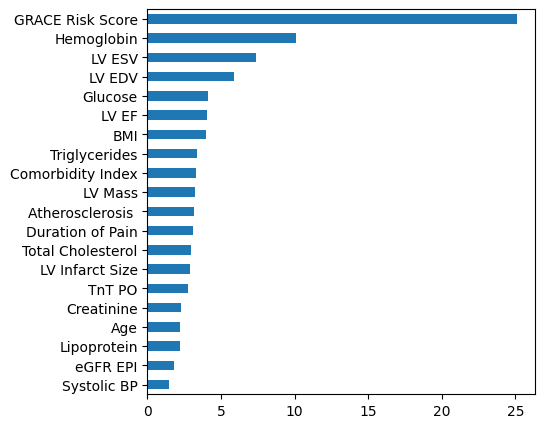

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(catboost.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

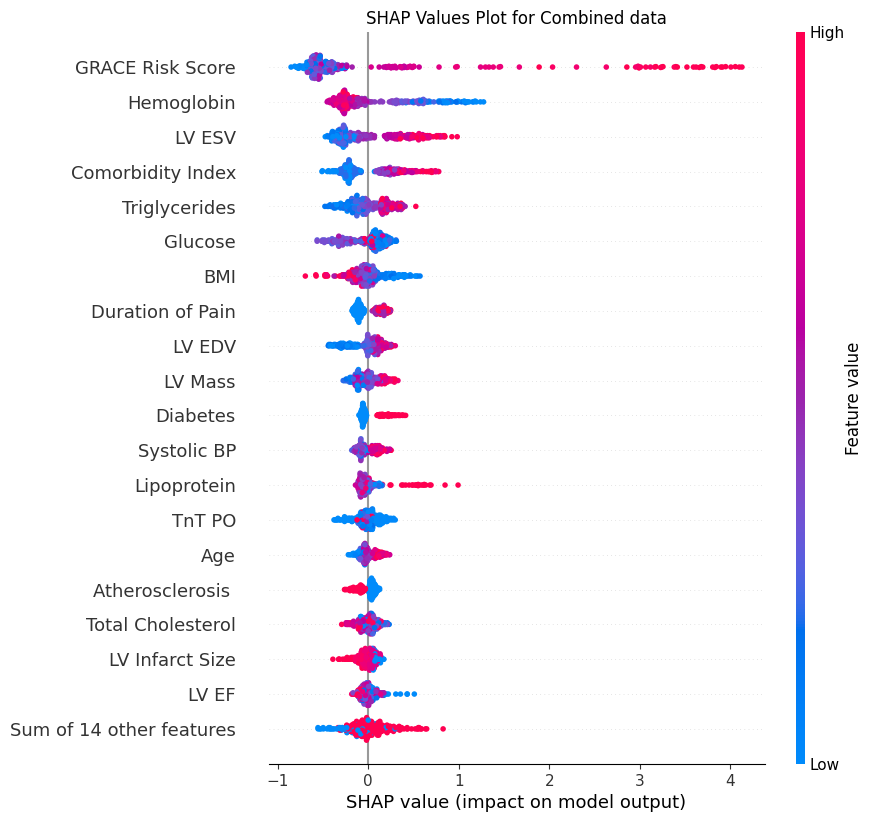

In [ ]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train), max_display=20)

## Catboost on selected features

<Axes: >

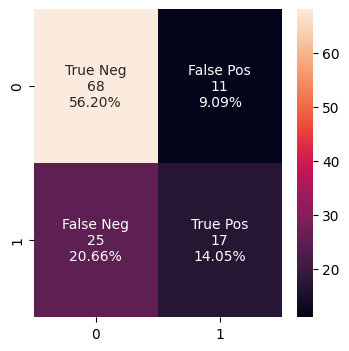

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,catboost_selected.predict(X_test_sfs))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

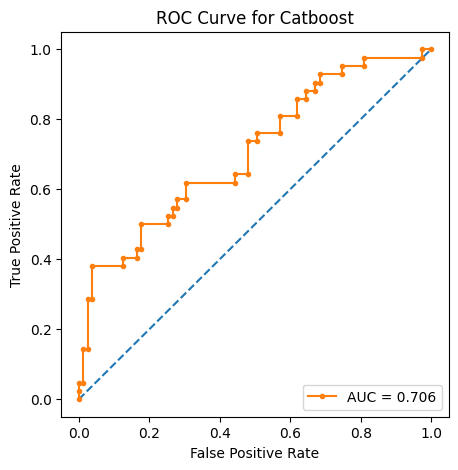

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, catboost_selected.predict_proba(X_test_sfs)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, catboost_selected.predict_proba(X_test_sfs)[:,1]):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

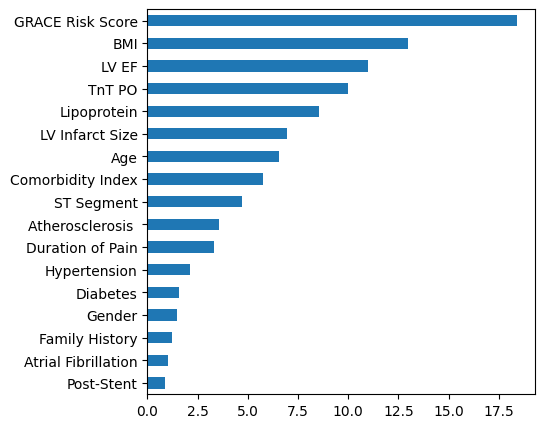

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(catboost_selected.feature_importances_, index=X_train_sfs.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

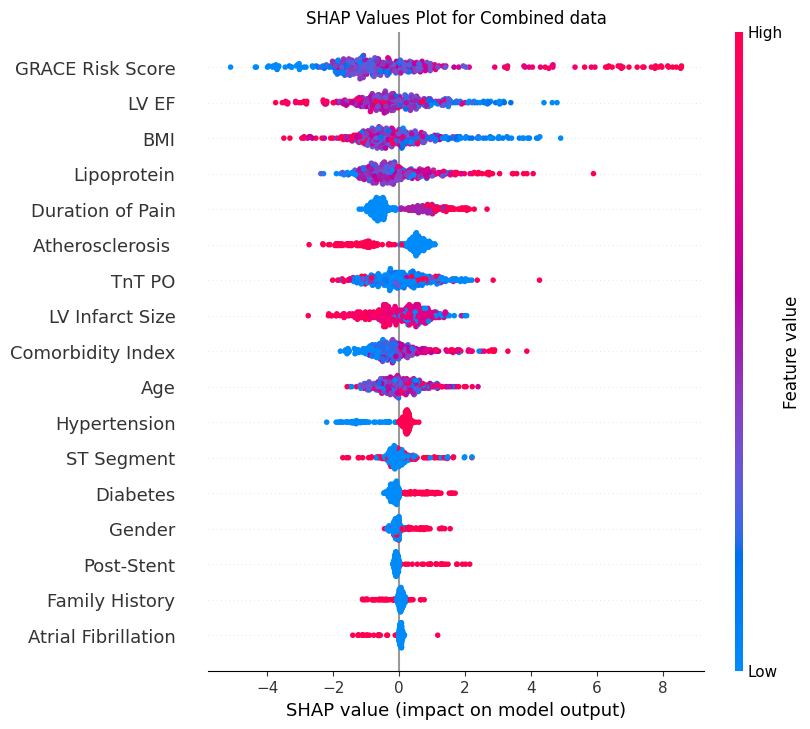

In [ ]:
explainer = shap.TreeExplainer(catboost_selected)
shap_values = explainer.shap_values(X_train_sfs)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train_sfs), max_display=20)

## Random Forest

<Axes: >

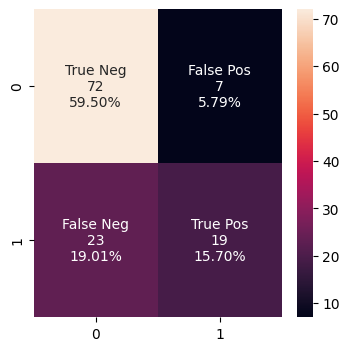

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,rf.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

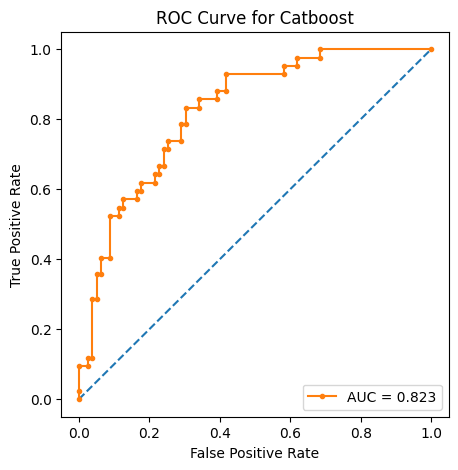

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

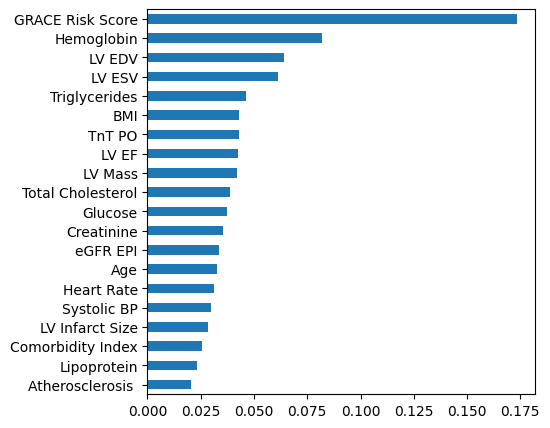

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(rf.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

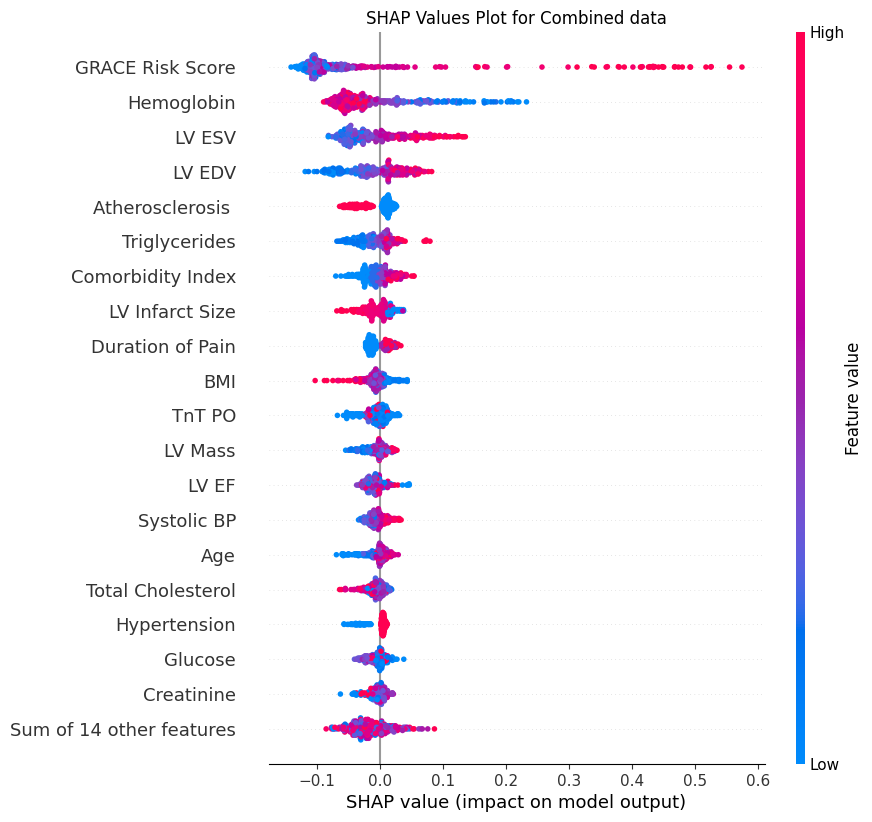

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train)[:,:,1], max_display=20)

## Logistic Regression

<Axes: >

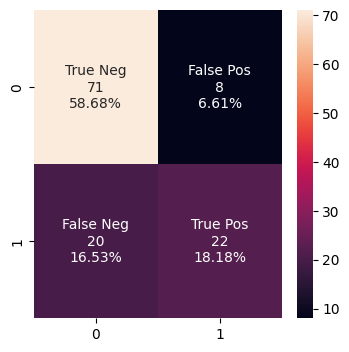

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,logreg.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

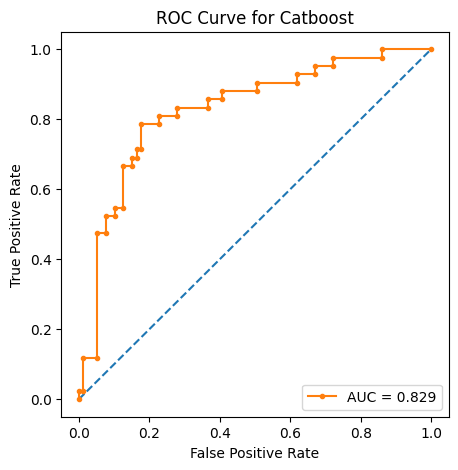

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

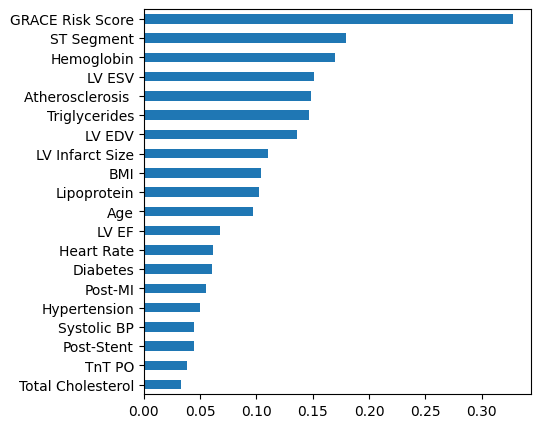

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(np.abs(logreg.coef_[0]), index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

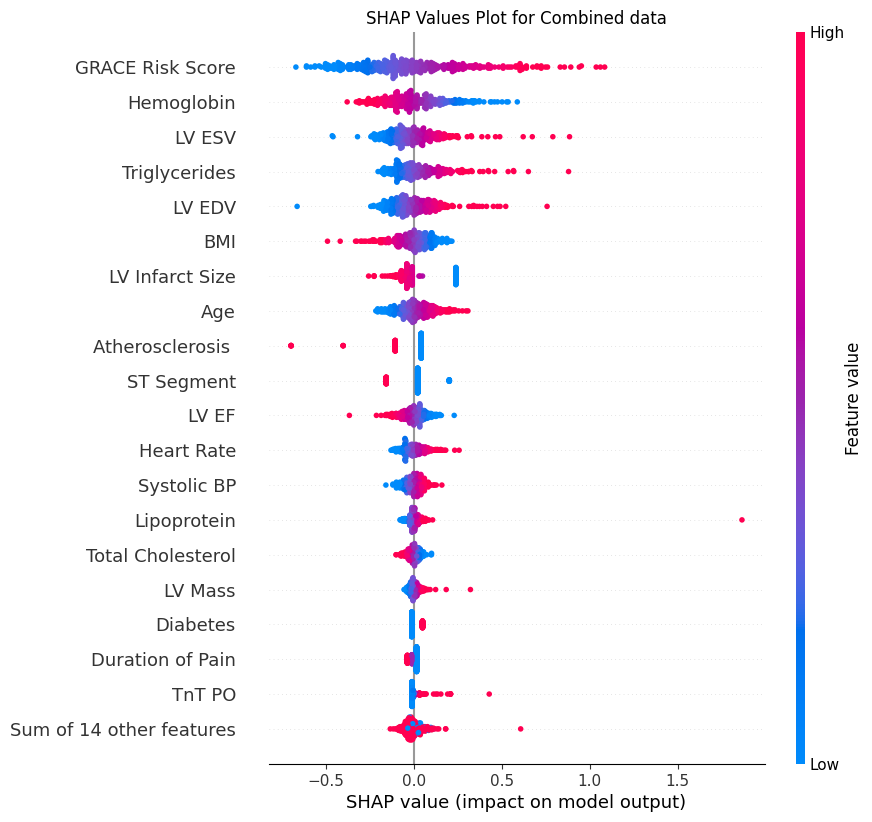

In [ ]:
explainer = shap.LinearExplainer(logreg,X_train)
shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train), max_display=20)

## SVM

<Axes: >

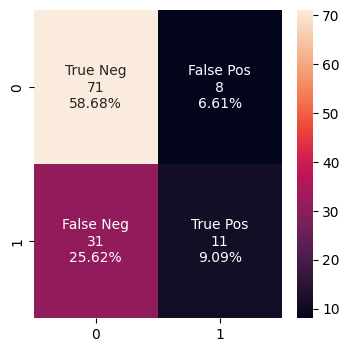

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,svm.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

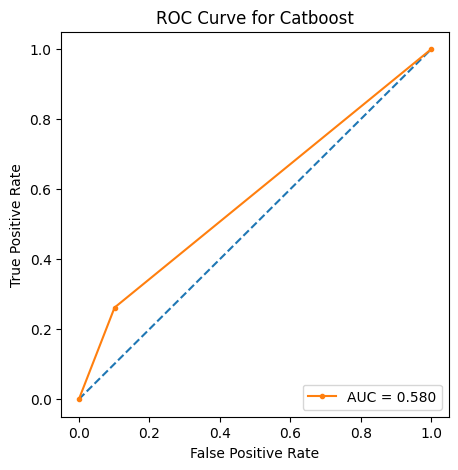

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, svm.predict(X_test))
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, svm.predict(X_test)):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

Kernel is not linear, so SVM does not saves coefs for feature importance

  0%|          | 0/363 [00:00<?, ?it/s]

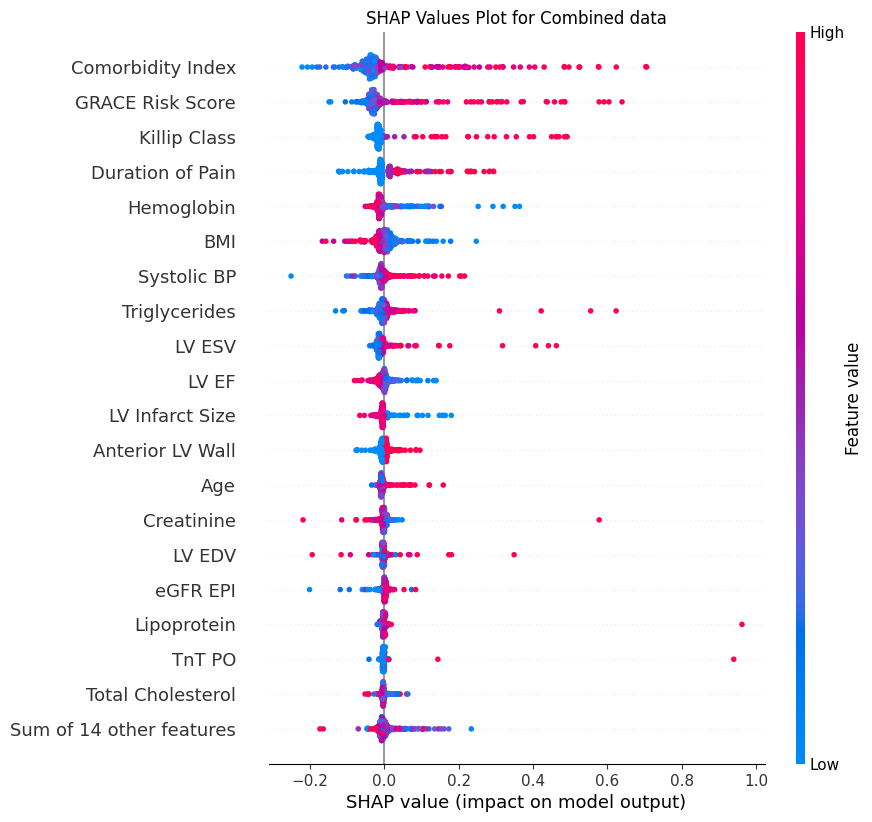

In [ ]:
explainer = shap.KernelExplainer(svm.predict,shap.kmeans(X_train, 50))
#shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train), max_display=20)

## Decision Tree

<Axes: >

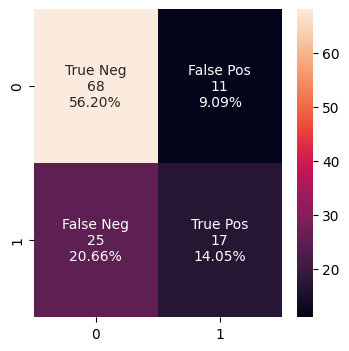

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,dt.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

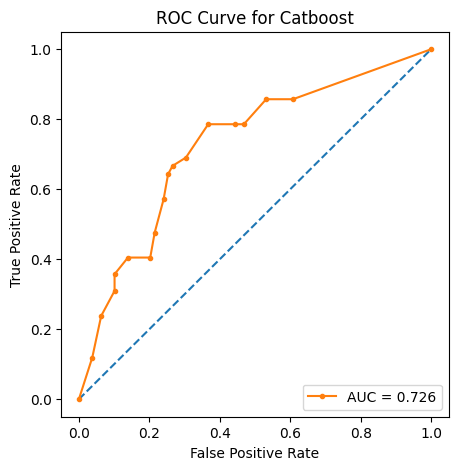

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for Catboost")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

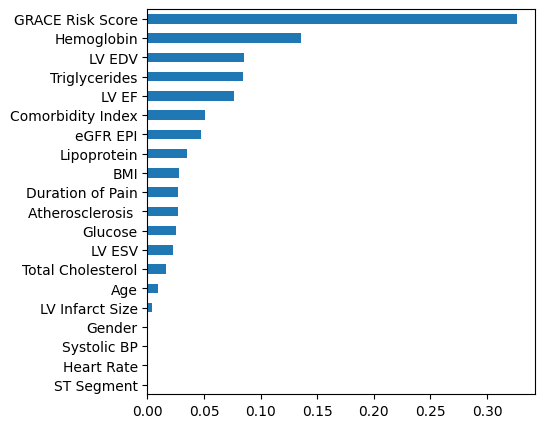

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(dt.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

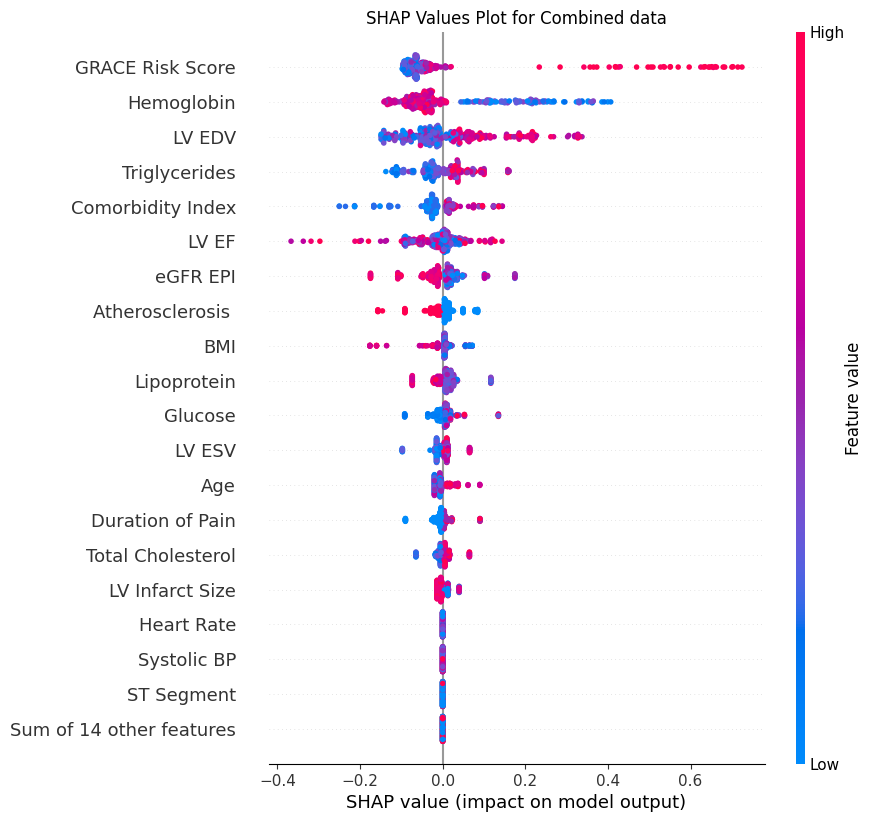

In [ ]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train)[:,:,1], max_display=20)

## AutoML Baseline

<Axes: >

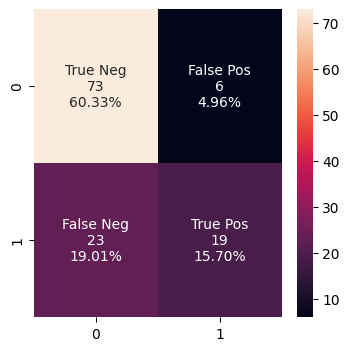

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,baseline.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

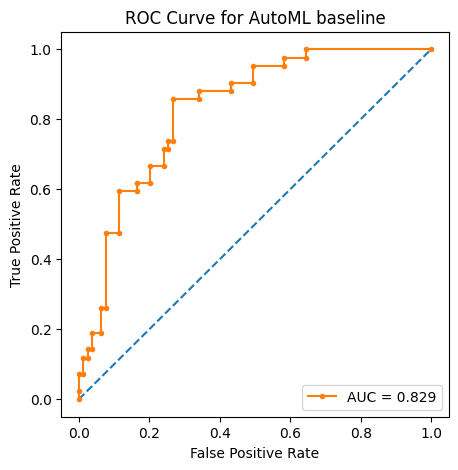

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for AutoML baseline")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

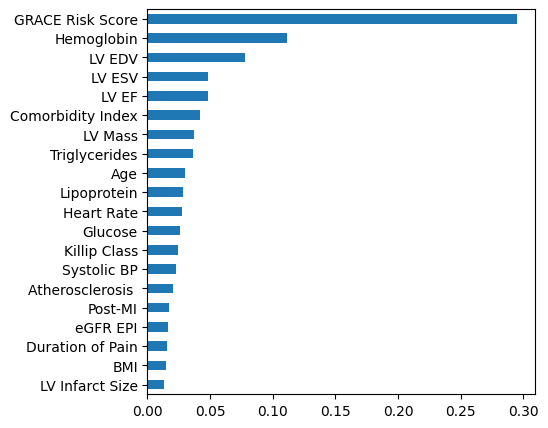

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(baseline.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

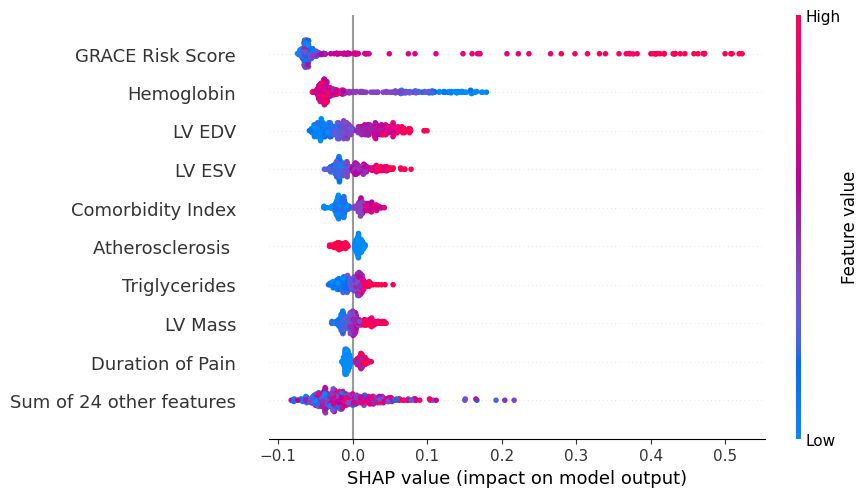

In [ ]:
explainer = shap.TreeExplainer(baseline.model.estimator)
shap_values = explainer.shap_values(X_train)
shap.plots.beeswarm(explainer(X_train)[:,:,1])